In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load("en_core_web_sm")

In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/fatma/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

In [3]:
twitter_rac_test_df = pd.read_csv("../../../Data/wikipedia_toxicity/wp_tox_data_test.csv")

In [4]:
twitter_rac_test_df.columns

Index(['index', 'Text', 'ed_label_0', 'ed_label_1', 'oh_label',
       'Text_clean_for_BERT', 'Text_clean', 'LSTM_prediction',
       'BiLSTM_prediction', 'BERT_prediction_no_stem', 'NFT_BERT_prediction',
       'BERT_NFT_wtp_tox_clean_text128', 'BERT_FT_diverse_ds_generlization'],
      dtype='object')

In [5]:
data_test_correct_Bert_prediction = twitter_rac_test_df[twitter_rac_test_df.BERT_prediction_no_stem == twitter_rac_test_df.oh_label]

data_test_wrong_Bert_prediction = twitter_rac_test_df[twitter_rac_test_df.BERT_prediction_no_stem != twitter_rac_test_df.oh_label]

In [6]:
len(data_test_correct_Bert_prediction), len(data_test_wrong_Bert_prediction)

(45355, 1946)

In [7]:
TP = data_test_correct_Bert_prediction[data_test_correct_Bert_prediction["BERT_prediction_no_stem"] == 1]
TN = data_test_correct_Bert_prediction[data_test_correct_Bert_prediction["BERT_prediction_no_stem"] == 0]

In [8]:
FP = data_test_wrong_Bert_prediction[data_test_wrong_Bert_prediction["BERT_prediction_no_stem"] == 1]
FN = data_test_wrong_Bert_prediction[data_test_wrong_Bert_prediction["BERT_prediction_no_stem"] == 0]

In [9]:
len(TP),len(TN),len(FP), len(FN)

(3436, 41919, 859, 1087)

## get the linguistic features in the dataset

In [10]:
def return_pos_features(doc):
  text = []
  lemma = []
  pos = []
  tag = []
  dep = []
  shape = []
  is_alpha = []
  is_stop = []
  for token in doc:
      text.append(token.text)
      lemma.append(token.lemma_)
      pos.append(token.pos_)
      tag.append(token.tag_)
      dep.append(token.dep_)
      shape.append(token.shape_)
      is_alpha.append(token.is_alpha)
      is_stop.append(token.is_stop)
  featurs_df = pd.DataFrame.from_dict({"text":text,"lemma":lemma,"pos":pos,"tag":tag,"dep":dep,"shape":shape,"is_alpha":is_alpha,"is_stop":is_stop})
  return featurs_df

def return_NERT_featurs(docs):
  text = []
  ner_label = []
  for ent in docs.ents:
      text.append(ent.text)
      ner_label.append(ent.label_)
  featurs_df = pd.DataFrame.from_dict({"text":text,"ner_label":ner_label})
  return featurs_df

In [11]:
nlp.max_length = 19208335

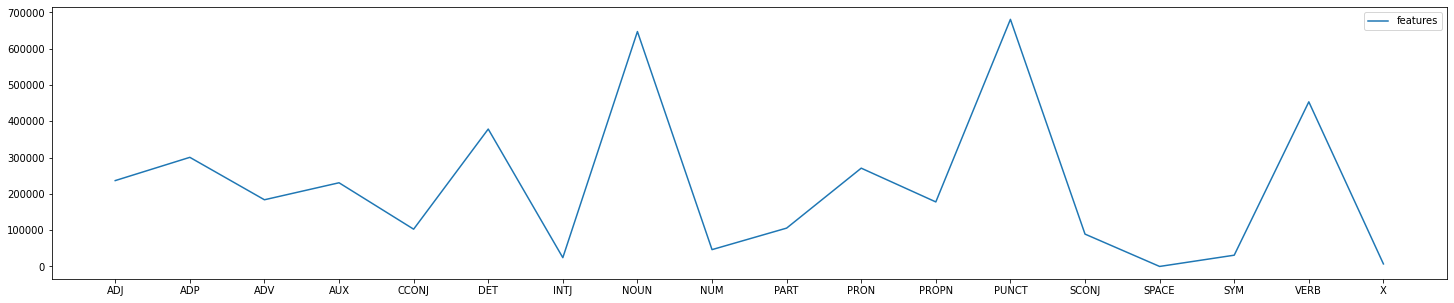

In [12]:
#data_correct_prediction_docs = "/n".join(data_test_correct_Bert_prediction["Text_clean_for_BERT"])
#data_wrong_prediction_docs = "/n".join(data_test_wrong_Bert_prediction["Text_clean_for_BERT"])
data_docs = " ".join(twitter_rac_test_df["Text_clean_for_BERT"])
#data_correct_prediction_features = nlp(data_correct_prediction_docs, disable = ['ner', 'parser'])
#data_wrong_prediction_features = nlp(data_wrong_prediction_docs, disable = ['ner', 'parser'])
data_docs_features = nlp(data_docs, disable = ['ner', 'parser'])
#data_correct_prediction_features_df = return_pos_features(data_correct_prediction_features) 
#data_wrong_prediction_features_df = return_pos_features(data_wrong_prediction_features) 
data_docs_features_df = return_pos_features(data_docs_features) 

import matplotlib.pyplot as plt
plt.subplots(figsize=(25, 5))
#plt.plot(data_correct_prediction_features_df.groupby(data_correct_prediction_features_df["pos"]).pos.count(), label="correct_prediction_features")
#plt.plot(data_wrong_prediction_features_df.groupby(data_wrong_prediction_features_df["pos"]).pos.count(),label="wrong_prediction_features")
plt.plot(data_docs_features_df.groupby(data_docs_features_df["pos"]).pos.count(),label="features")

plt.legend()

## get the attribution scores of all the unique words from BERT FT on Twitter racism DS
## test dataset

In [13]:
attribution_scores = pd.read_csv("attribution_scores/bert_with_fine_tuning/wikipedia_toxicity_1000_data_fine_tuned_bert_attribution_scores.csv")

In [14]:
len(attribution_scores)

43496

In [15]:
attribution_scores.head()

,words,attribution,abs_attribution
0,this,0.282146,0.282146
1,a,0.063024,0.063024
2,free,0.411518,0.411518
3,site,-0.014177,0.014177
4,",",-0.038212,0.038212


In [16]:
attribution_scores["abs_attribution"] = [np.absolute(i) for i in attribution_scores.attribution]
word_attribution_grp = attribution_scores.groupby(attribution_scores["words"])

In [17]:
import numpy as np

unique_words = []
avg_attribution = []
avg_abs_attribution = []
no_occurances = []
for name,grp in word_attribution_grp:
    unique_words.append(name)
    avg_attribution.append(np.mean(grp["attribution"]))
    avg_abs_attribution.append(np.mean(grp["abs_attribution"]))
    no_occurances.append(len(grp["attribution"]))

In [18]:
word_attribution_unique = {}
word_attribution_unique["unique_words"] = unique_words
word_attribution_unique["attribution"] = avg_attribution
word_attribution_unique["abs_attribution"] = avg_abs_attribution
word_attribution_unique["No_occurences"] = no_occurances

In [19]:
word_attribution_unique_df = pd.DataFrame.from_dict(word_attribution_unique)
len(word_attribution_unique_df)

5844

<AxesSubplot:>

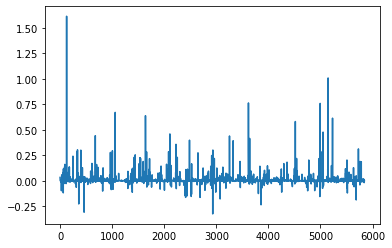

In [20]:
word_attribution_unique_df["attribution"].plot()

<AxesSubplot:>

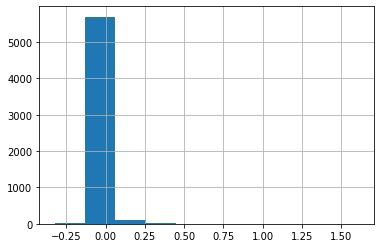

In [21]:
word_attribution_unique_df["attribution"].hist()

In [22]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].min(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].max(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].mean(),word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0].std()

(unique_words                 !
 attribution        5.04754e-10
 abs_attribution    5.04754e-10
 No_occurences                1
 dtype: object,
 unique_words             |
 attribution        1.61225
 abs_attribution    1.61225
 No_occurences         1318
 dtype: object,
 attribution        0.016433
 abs_attribution    0.016791
 No_occurences      9.312443
 dtype: float64,
 attribution         0.069402
 abs_attribution     0.069610
 No_occurences      51.541446
 dtype: float64)

In [23]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].min(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].max(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].mean(),word_attribution_unique_df[word_attribution_unique_df["attribution"] < 0].std()

(unique_words              ##10
 attribution           -0.32541
 abs_attribution    2.90769e-08
 No_occurences                1
 dtype: object,
 unique_words                 ~
 attribution       -2.55555e-08
 abs_attribution        0.32541
 No_occurences             1906
 dtype: object,
 attribution       -0.002401
 abs_attribution    0.002508
 No_occurences      6.325588
 dtype: float64,
 attribution         0.015245
 abs_attribution     0.015392
 No_occurences      56.132030
 dtype: float64)

In [24]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] > 0.5].sort_values(by=["attribution"])

,unique_words,attribution,abs_attribution,No_occurences
4517,pussy,0.580278,0.580278,1
5231,sucks,0.613259,0.613259,2
1640,bastards,0.637385,0.637385,1
1059,##yer,0.669741,0.669741,1
4994,sigh,0.757825,0.757825,1
3617,les,0.762357,0.762357,2
5146,stalin,1.007198,1.007198,1
126,##bid,1.612252,1.612252,1


In [25]:
word_attribution_unique_df[word_attribution_unique_df["attribution"] < -0.1].sort_values(by=["attribution"])

,unique_words,attribution,abs_attribution,No_occurences
2931,fry,-0.325410,0.325410,1
462,##ist,-0.308695,0.308696,2
3859,mexican,-0.236100,0.236100,2
359,##hc,-0.227830,0.227830,1
5686,watching,-0.188449,0.188452,3
3073,hacking,-0.178768,0.178785,2
2688,evil,-0.163738,0.163784,3
2411,diamonds,-0.163398,0.163398,1
4988,sick,-0.155166,0.155166,1
2518,dt,-0.154143,0.154143,2


In [26]:
word_attribution_unique_df.sort_values(by=["attribution"],ascending=True)

,unique_words,attribution,abs_attribution,No_occurences
2931,fry,-0.325410,0.325410,1
462,##ist,-0.308695,0.308696,2
3859,mexican,-0.236100,0.236100,2
359,##hc,-0.227830,0.227830,1
5686,watching,-0.188449,0.188452,3
...,...,...,...,...
1059,##yer,0.669741,0.669741,1
4994,sigh,0.757825,0.757825,1
3617,les,0.762357,0.762357,2
5146,stalin,1.007198,1.007198,1


In [27]:
word_attribution_unique_df.head(10)

,unique_words,attribution,abs_attribution,No_occurences
0,!,3.260636e-02,3.638715e-02,172
1,##0,3.290637e-07,4.538458e-06,4
2,##00,6.449806e-06,6.449806e-06,2
3,##1,1.844155e-06,1.844155e-06,4
4,##10,-7.690908e-06,7.690908e-06,2
5,##16,-8.963450e-07,8.963450e-07,2
6,##17,-9.840908e-06,9.840908e-06,2
7,##19,-2.827992e-07,2.827992e-07,1
8,##2,-2.715380e-07,3.183362e-06,9
9,##20,-2.290867e-06,2.290867e-06,1


In [28]:
word_attribution_unique_df.tail(10)

,unique_words,attribution,abs_attribution,No_occurences
5834,youtube,1.140927e-05,1.140927e-05,3
5835,yun,1.389698e-03,1.389698e-03,1
5836,z,-3.761066e-07,3.761066e-07,1
5837,za,1.894231e-07,1.894231e-07,1
5838,zero,-1.898833e-02,1.898833e-02,2
5839,zoe,8.031916e-06,8.031916e-06,1
5840,{,-4.025820e-06,4.025820e-06,16
5841,|,4.709261e-08,2.613419e-06,56
5842,},-9.403608e-06,9.403608e-06,9
5843,~,-3.670409e-06,3.880969e-06,4


In [29]:
#word_attribution_unique_df.to_csv("attribution_Scores/Fine-tuned_BERT/BERT_FT_on_Twitter_racism_1000_data_attribution_scores_grped_by_word.csv", index=False)

In [30]:
word_attribution_unique_df.corr()

,attribution,abs_attribution,No_occurences
attribution,1.000000,0.852181,-0.007565
abs_attribution,0.852181,1.000000,-0.008202
No_occurences,-0.007565,-0.008202,1.000000


## attribution scores of the linguistic features in normal text

In [31]:
def normalize(x):
    amin, amax = min(x), max(x)
    for i, val in enumerate(x):
         x[i] = (val-amin) / (amax-amin)
    return x        

In [32]:
def importance_score_of_ADJ_in_features (features):
    Twitter_rac_adj = features[features["pos"]=="ADJ"]
    adj_text = Twitter_rac_adj["text"].values
    attribution_adj = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adj_text]
    attribution_adj = normalize(attribution_adj)
    adj_attribution = {}
    adj_attribution["adj"] = adj_text
    adj_attribution["adj_attribution"] = attribution_adj
    adj_attribution_df = pd.DataFrame.from_dict(adj_attribution)
    return adj_attribution_df

In [33]:
def importance_score_of_PRON_in_features (features):
    Twitter_rac_pron = features[features["pos"]=="PRON"]
    pron_text = Twitter_rac_pron["text"].values
    attribution_pron = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in pron_text]
    attribution_pron = normalize(attribution_pron)
    pron_attribution = {}
    pron_attribution["pron"] = pron_text
    pron_attribution["pron_attribution"] = attribution_pron
    pron_attribution_df = pd.DataFrame.from_dict(pron_attribution)
    return pron_attribution_df

In [34]:
def importance_score_of_DET_in_features (features):
    Twitter_rac_det = features[features["pos"]=="DET"]
    det_text = Twitter_rac_det["text"].values
    attribution_det = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in det_text]
    attribution_det = normalize(attribution_det)
    det_attribution = {}
    det_attribution["det"] = det_text
    det_attribution["det_attribution"] = attribution_det
    det_attribution_df = pd.DataFrame.from_dict(det_attribution)
    return det_attribution_df

In [35]:
def importance_score_of_ADV_in_features (features):
    Twitter_rac_adv = features[features["pos"]=="ADV"]
    adv_text = Twitter_rac_adv["text"].values
    attribution_adv = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in adv_text]
    attribution_adv = normalize(attribution_adv)
    adv_attribution = {}
    adv_attribution["adv"] = adv_text
    adv_attribution["adv_attribution"] = attribution_adv
    adv_attribution_df = pd.DataFrame.from_dict(adv_attribution)
    return adv_attribution_df

In [36]:
def importance_score_of_NOUN_in_features (features):
    Twitter_rac_noun = features[features["pos"]=="NOUN"]
    noun_text = Twitter_rac_noun["text"].values
    attribution_noun = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in noun_text]
    attribution_noun = normalize(attribution_noun)
    noun_attribution = {}
    noun_attribution["noun"] = noun_text
    noun_attribution["noun_attribution"] = attribution_noun
    noun_attribution_df = pd.DataFrame.from_dict(noun_attribution)
    return noun_attribution_df

In [37]:
def importance_score_of_VERB_in_features (features):
    Twitter_rac_verb = features[features["pos"]=="VERB"]
    verb_text = Twitter_rac_verb["text"].values
    attribution_verb = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in verb_text]
    attribution_verb = normalize(attribution_verb)
    verb_attribution = {}
    verb_attribution["verb"] = verb_text
    verb_attribution["verb_attribution"] = attribution_verb
    verb_attribution_df = pd.DataFrame.from_dict(verb_attribution)
    return verb_attribution_df

In [38]:
def importance_score_of_PUNCT_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PUNCT"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["punc"] = punc_text
    punc_attribution["punc_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [39]:
def importance_score_of_PROPN_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="PROPN"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["propn"] = punc_text
    punc_attribution["propn_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [40]:
def importance_score_of_AUX_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="AUX"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["aux"] = punc_text
    punc_attribution["aux_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

In [41]:
def importance_score_of_ADP_in_features (features):
    Twitter_rac_punc = features[features["pos"]=="ADP"]
    punc_text = Twitter_rac_punc["text"].values
    attribution_punc = [word_attribution_unique_df[word_attribution_unique_df["unique_words"] == i]["abs_attribution"].values[0] if i in word_attribution_unique_df["unique_words"].values else 0 for i in punc_text]
    attribution_punc = normalize(attribution_punc)
    punc_attribution = {}
    punc_attribution["adp"] = punc_text
    punc_attribution["adp_attribution"] = attribution_punc
    punc_attribution_df = pd.DataFrame.from_dict(punc_attribution)
    return punc_attribution_df

## attribution scores of POS in correct predicted docs

In [42]:
adj_attribution_df_correct_txt = importance_score_of_ADJ_in_features(data_docs_features_df)
pron_attribution_df_correct_txt = importance_score_of_PRON_in_features(data_docs_features_df)
noun_attribution_df_correct_txt = importance_score_of_NOUN_in_features(data_docs_features_df)
det_attribution_df_correct_txt = importance_score_of_DET_in_features(data_docs_features_df)
verb_attribution_df_correct_txt = importance_score_of_VERB_in_features(data_docs_features_df)
punc_attribution_df_correct_txt = importance_score_of_PUNCT_in_features(data_docs_features_df)
adv_attribution_df_correct_txt = importance_score_of_ADV_in_features(data_docs_features_df)
aaux_attribution_df_correct_txt = importance_score_of_AUX_in_features(data_docs_features_df)
propn_attribution_df_correct_txt = importance_score_of_PROPN_in_features(data_docs_features_df)
adp_attribution_df_correct_txt = importance_score_of_ADP_in_features(data_docs_features_df)

In [55]:
adj_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_adj_tags_importance_scores_df.csv",index=False)
pron_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_pron_tags_importance_scores_df.csv",index=False)
noun_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_noun_tags_importance_scores_df.csv",index=False)
det_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_det_tags_importance_scores_df.csv",index=False)
verb_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_verb_tags_importance_scores_df.csv",index=False)
punc_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_punc_tags_importance_scores_df.csv",index=False)
adv_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_adv_tags_importance_scores_df.csv",index=False)
aaux_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_aux_tags_importance_scores_df.csv",index=False)
propn_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_propn_tags_importance_scores_df.csv",index=False)
adp_attribution_df_correct_txt.to_csv("attribution_scores/bert_with_fine_tuning/wtp-tox_adp_tags_importance_scores_df.csv",index=False)

In [56]:
det_attribution_df_correct_txt.det.unique(), len(det_attribution_df_correct_txt.det.unique())

(array(['the', 'an', 'a', 'its', 'that', 'both', 'which', 'another', 'my',
        'their', 'these', 'any', 'this', 'each', 'either', 'twice', 'no',
        'all', 'some', 'what', 'his', 'eds', 'those', 'whatever', 'every',
        'your', 'n', 'her', 'our', 'half', 'such', 'quite', 'whose',
        'neither', 'rashis', 'wether', 'thier', 'rhobite', 'whichever',
        'fuck', 'hee', 'thy', 'many', 'af', 'yours', 'ours', 'bethe',
        'tthe', 'futher', 's', 'leastthat', '72.244.64.149s', 'teh',
        'bitchez', 'eldery', 'transilvania.3dardeal.3f.3f.3f', 'aiv',
        'severall', 'd', 'amongst', 'sub-', 'ofcurse', 'there', 'ther',
        'ts', 'terryeo', 'articles.the', 'history21==', 'wich', 'myg0',
        'twentynine', 'mc', 'agree.the', 'e6', 'sz', 'alf', 'nlsiu',
        'yahoo-', 'twothe', 'thatthe', 'real', 'p', '.what',
        'ridiculous.the', 'noticeboard/3rr', 'asl_november.png', 'mel',
        'pilots==', '5:00am', 'ip', 'yous', 'tothis', '\\',
        'stratifiest

In [57]:
spacy.glossary

<module 'spacy.glossary' from '/home/fatma/.local/lib/python3.6/site-packages/spacy/glossary.py'>

In [58]:
punc_attribution_df_correct_txt.punc.unique(), len(punc_attribution_df_correct_txt.punc.unique())

(array(['`', ';', ',', ..., '.priyadarshivishal23', '|best',
        'wikipedia.can'], dtype=object),
 1077)

In [72]:
punc_attribution_df_correct_txt.punc.unique()[:1000]

array(['`', ';', ',', '-', '.', ':', '?', '(', ')', '=', '/', '...', '*',
       '!', '~', '~~~', '~~~~', '{', '}', '[', ']', '..', '-d',
       '/archive', '.com', 'clarification==', ':1', 'ps', '-/',
       'filename.jpg', '0000', 'meetup==', 'tkz.jpg', 'border=0', '|',
       'archive6wikipedia', 'thumb|200px|an', '-1', 'first.i', '.net',
       'g.', '~~james', '.i', '\\', 'etc.but', '.just', '-economics',
       '-1901', '-and', '-much', 'thumb|250px|for', '/shutdown', '.if',
       '.in', '-fm', '-tv', '.skip', 'brogden==', '-pat', '-ril-',
       '-brad', 'categorisation==', '+', 'image:12d.jpg',
       'image:25d1.jpg==', 'nateji77', '/soul', '-|', 'smith==', 'b.boys',
       'imacg5.jpg==', '09:36am', ':*', '/y/', '-2', 'block===', '-tari',
       '-nu', 'stephenb|', '^^', 'brazil4linux', '-~~-', '.es', '.and',
       'alternative===', '-w', '-gelston', '-0', '0', 'problem===', '-p',
       'ashe==', '.so', 'nomination==', 'sci.physics.research', '/essjay',
       '.you', '-ra

In [59]:
det_attribution_df_correct_txt.det.unique()

array(['the', 'an', 'a', 'its', 'that', 'both', 'which', 'another', 'my',
       'their', 'these', 'any', 'this', 'each', 'either', 'twice', 'no',
       'all', 'some', 'what', 'his', 'eds', 'those', 'whatever', 'every',
       'your', 'n', 'her', 'our', 'half', 'such', 'quite', 'whose',
       'neither', 'rashis', 'wether', 'thier', 'rhobite', 'whichever',
       'fuck', 'hee', 'thy', 'many', 'af', 'yours', 'ours', 'bethe',
       'tthe', 'futher', 's', 'leastthat', '72.244.64.149s', 'teh',
       'bitchez', 'eldery', 'transilvania.3dardeal.3f.3f.3f', 'aiv',
       'severall', 'd', 'amongst', 'sub-', 'ofcurse', 'there', 'ther',
       'ts', 'terryeo', 'articles.the', 'history21==', 'wich', 'myg0',
       'twentynine', 'mc', 'agree.the', 'e6', 'sz', 'alf', 'nlsiu',
       'yahoo-', 'twothe', 'thatthe', 'real', 'p', '.what',
       'ridiculous.the', 'noticeboard/3rr', 'asl_november.png', 'mel',
       'pilots==', '5:00am', 'ip', 'yous', 'tothis', '\\',
       'stratifiesthat', 'towards'

In [73]:
pron_attribution_df_correct_txt.pron.unique(), len(pron_attribution_df_correct_txt.pron.unique())

(array(['i', 'anything', 'it', 'us', 'you', 'we', 'what', 'itself', 'she',
        'there', 'me', 'he', 'who', 'they', 'something', 'them', 'nothing',
        'him', 'themselves', 'whoever', 'himself', 'someone', 'everyone',
        'one', 'nobody', 'everything', 'whom', 'everybody', 'anyone',
        'yourself', 'anybody', 'thee', 'myself', 'ourselves', 'her',
        'somebody', 'db', 'my', 'whatever', 'herself', 'ya', 'eye==',
        'yourselves', 's', 'yours', 'mine', 'hey', 'theirs', 'u', 'hers',
        'his', 'yu', 'id=15381', 'em', 'ybm', 'vf', 'your', 'thm', 'its',
        'moc', 'kaustuv|', 'ours', 'ip', 'ihr', 'sango123s', 'youself',
        'verself', 'urself', 'sg', 'wmc', 'islamism==', 'oneself',
        'bhangra==', 'hebrew', 'themself', 'ce', 'whore', 'chandramaham==',
        'mj', 'wr', 'typer525', 'page==', 'n00b', 'cuba==', 'wat',
        'you===', 'vp', 'mvp', 'project_formula_one',
        'creating_an_article_about_yourself', 'yoself', 'tyan', 'bs', 'e6',
      

In [60]:
import string

string.punctuation
len([i for i in punc_attribution_df_correct_txt.punc.unique() if i not in string.punctuation])

1053

In [61]:
aaux_attribution_df_correct_txt.aux.unique(), len(aaux_attribution_df_correct_txt.aux.unique())

(array(['is', 'are', 'am', 'be', 'has', 'was', 'have', 'been', 'does',
        'do', 'being', 'were', 'get', 'had', 'did'], dtype=object),
 15)

In [62]:
print("ADJ",np.mean(adj_attribution_df_correct_txt["adj_attribution"]))
print("PRON", np.mean(pron_attribution_df_correct_txt["pron_attribution"]))
print("NOUN",np.mean(noun_attribution_df_correct_txt["noun_attribution"]))
print("DET",np.mean(det_attribution_df_correct_txt["det_attribution"]))
print("VERB",np.mean(verb_attribution_df_correct_txt["verb_attribution"]))
print("PUNC",np.mean(punc_attribution_df_correct_txt["punc_attribution"]))
print("ADV",np.mean(adv_attribution_df_correct_txt["adv_attribution"]))
print("PROPN",np.mean(propn_attribution_df_correct_txt["propn_attribution"]))
print("AUX",np.mean(aaux_attribution_df_correct_txt["aux_attribution"]))
print("ADP",np.mean(adp_attribution_df_correct_txt["adp_attribution"]))

ADJ 0.006465342224730503
PRON 0.05721550325223163
NOUN 0.004069814831502052
DET 0.019500670976556826
VERB 0.007651133887061637
PUNC 0.11317075472019596
ADV 0.0118634767063226
PROPN 0.004939452630014255
AUX 0.3259483208504355
ADP 0.00928096732513712


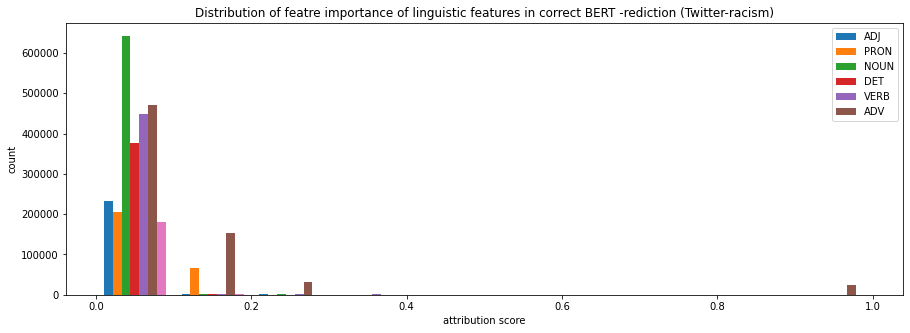

In [63]:
plt.subplots(figsize=(15, 5))
plt.hist([adj_attribution_df_correct_txt["adj_attribution"],
          pron_attribution_df_correct_txt["pron_attribution"],
          noun_attribution_df_correct_txt["noun_attribution"],
          det_attribution_df_correct_txt["det_attribution"],
         verb_attribution_df_correct_txt["verb_attribution"],
         punc_attribution_df_correct_txt["punc_attribution"],
         adv_attribution_df_correct_txt["adv_attribution"]],
         label=["ADJ","PRON","NOUN","DET","VERB","ADV"], stacked=False)
plt.xlabel("attribution score")
plt.ylabel("count")
plt.title("Distribution of featre importance of linguistic features in correct BERT -rediction (Twitter-racism)")
plt.legend()

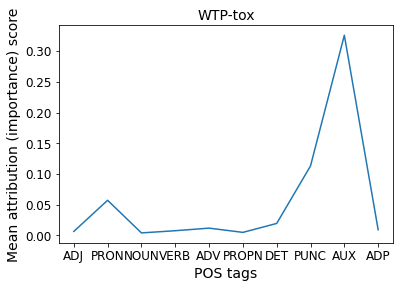

In [66]:
plt.plot(["ADJ","PRON","NOUN","VERB","ADV", "PROPN","DET","PUNC", "AUX", "ADP"],
        [adj_attribution_df_correct_txt["adj_attribution"].mean(),
          pron_attribution_df_correct_txt["pron_attribution"].mean(),
          noun_attribution_df_correct_txt["noun_attribution"].mean(),
         verb_attribution_df_correct_txt["verb_attribution"].mean(),
         adv_attribution_df_correct_txt["adv_attribution"].mean(),         
         propn_attribution_df_correct_txt["propn_attribution"].mean(),
         det_attribution_df_correct_txt["det_attribution"].mean(),
         punc_attribution_df_correct_txt["punc_attribution"].mean(),
         aaux_attribution_df_correct_txt["aux_attribution"].mean(),
         adp_attribution_df_correct_txt["adp_attribution"].mean()])
plt.title("WTP-tox", fontsize=14)
plt.ylabel("Mean attribution (importance) score", fontsize=14)
plt.xlabel("POS tags",fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("WTP-tox-pos-tags.eps",format='eps',bbox_inches='tight')

In [68]:
pos_tags_importance_scores_df = pd.DataFrame.from_dict({"POS_tag":["ADJ","PRON","NOUN","VERB","ADV", "PROPN","DET","PUNC", "AUX", "ADP"],
                                                        "mean_importance_score":[adj_attribution_df_correct_txt["adj_attribution"].mean(),
                                                          pron_attribution_df_correct_txt["pron_attribution"].mean(),
                                                          noun_attribution_df_correct_txt["noun_attribution"].mean(),
                                                         verb_attribution_df_correct_txt["verb_attribution"].mean(),
                                                         adv_attribution_df_correct_txt["adv_attribution"].mean(),         
                                                         propn_attribution_df_correct_txt["propn_attribution"].mean(),
                                                         det_attribution_df_correct_txt["det_attribution"].mean(),
                                                         punc_attribution_df_correct_txt["punc_attribution"].mean(),
                                                         aaux_attribution_df_correct_txt["aux_attribution"].mean(),
                                                         adp_attribution_df_correct_txt["adp_attribution"].mean()]})
pos_tags_importance_scores_df.to_csv("attribution_scores/bert_with_fine_tuning/wtp_tox_pos_tags_importance_scores_df.csv")

In [48]:
adj_attribution_df_wrong_txt[adj_attribution_df_wrong_txt["adj_attribution"]> 0.2].groupby("adj").adj_attribution.mean()

adj
canadian    0.703745
cock        0.391574
coward      0.285300
foul        0.213686
fuck        0.241367
fucking     0.254313
grave       0.311942
lesbian     0.328270
piss        0.266758
zionist     0.286048
Name: adj_attribution, dtype: float64

In [49]:
adj_attribution_df_correct_txt[adj_attribution_df_correct_txt["adj_attribution"]> 0.2].groupby("adj").adj_attribution.mean()

adj
13th        0.271237
canadian    0.703745
category    0.243524
cheese      0.300923
cock        0.391574
coward      0.285300
foul        0.213686
fuck        0.241367
fucking     0.254313
grave       0.311942
idiot       0.202676
lesbian     0.328270
piss        0.266758
shy         0.203305
zionist     0.286048
Name: adj_attribution, dtype: float64

In [50]:
adv_attribution_df_correct_txt[adv_attribution_df_correct_txt["adv_attribution"]>0.01].groupby("adv").adv_attribution.mean()

adv
ahead         0.014247
alongside     0.020291
bastard       0.073173
bet           0.013333
between       0.014018
cool          0.010401
course        0.032995
damn          0.024668
dead          0.019952
dumb          0.098101
ever          0.020644
exactly       0.012334
foul          0.213686
gay           0.062621
german        0.027864
hardly        0.012332
hmm           0.035957
home          0.042479
like          0.015759
live          0.017924
long          0.012047
narrow        0.021081
off           0.047133
often         0.048015
pointless     0.121406
ps            0.012496
real          0.019232
ricky         0.019310
sc            0.013846
slowly        0.046499
somehow       0.048971
totally       0.011765
u             0.020813
wat           0.255264
whatsoever    0.034378
whore         0.049515
why           0.011486
wide          0.021004
within        0.033167
x             0.042530
Name: adv_attribution, dtype: float64

In [51]:
noun_attribution_df_wrong_txt[noun_attribution_df_wrong_txt["noun_attribution"]> 0.2].groupby("noun").noun_attribution.mean()

noun
asshole        0.245114
bullshit       0.226847
candidate      0.559163
category       0.243524
cock           0.391574
conflict       0.312560
correlation    0.377746
coward         0.285300
dawn           0.298965
fuck           0.241367
fucking        0.254313
grave          0.311942
idiot          0.202676
idiots         0.226534
piss           0.266758
prick          0.209493
smell          1.277921
Name: noun_attribution, dtype: float64

In [52]:
noun_attribution_df_correct_txt[noun_attribution_df_correct_txt["noun_attribution"]> 0.5].groupby("noun").noun_attribution.mean()

noun
ca           0.842741
canadian     0.703745
candidate    0.559163
smell        1.277921
Name: noun_attribution, dtype: float64

## attribution scores of important words

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

In [40]:
train_df = pd.read_csv("../../../Data/Twitter_racism/Twitter_rac_data_train.csv").dropna()
test_df = pd.read_csv("../../../Data/Twitter_racism/Twitter_rac_data_test.csv").dropna()

vectorizer_train = TfidfVectorizer()
X = vectorizer_train.fit_transform(train_df["Text_clean"].values)
y = train_df["oh_label"].values

clf = MultinomialNB()
clf.fit(X, y)
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()
print(np.take(vectorizer_train.get_feature_names(), neg_class_prob_sorted[-10:]))
print(np.take(vectorizer_train.get_feature_names(), pos_class_prob_sorted[-10:]))

['get' 'people' 'would' 'your' 'andre' 'like' 'kat' 'they' 'you' 'mkr']
['prophet' 'jews' 'religion' 'blumenthal' 'they' 'mohammed' 'muslim' 'you'
 'muslims' 'islam']


In [47]:
word_attribution_unique_df[(word_attribution_unique_df["unique_words"] == "prophet")|
                          (word_attribution_unique_df["unique_words"] == "jew") | 
                          (word_attribution_unique_df["unique_words"] == "religion") |
                          (word_attribution_unique_df["unique_words"] == "blumenthal") |
                          (word_attribution_unique_df["unique_words"] == "mohammed") |
                          (word_attribution_unique_df["unique_words"] == "mohammed") |
                          (word_attribution_unique_df["unique_words"] == "muslim") |
                          (word_attribution_unique_df["unique_words"] == "muslims") |
                          (word_attribution_unique_df["unique_words"] == "islam")]

,unique_words,attribution,abs_attribution,No_occurences
2151,islam,0.621503,0.655102,91
2179,jew,0.498244,0.498244,17
2454,muslim,0.515682,0.526257,67
2692,prophet,0.267429,0.267429,17
2767,religion,0.293257,0.319499,14


In [46]:
word_attribution_unique_df[(word_attribution_unique_df["unique_words"] == "get")|
                          (word_attribution_unique_df["unique_words"] == "people") | 
                          (word_attribution_unique_df["unique_words"] == "andre") |
                          (word_attribution_unique_df["unique_words"] == "like") |
                          (word_attribution_unique_df["unique_words"] == "kat") |
                          (word_attribution_unique_df["unique_words"] == "mkr") |
                          (word_attribution_unique_df["unique_words"] == "would") |
                          (word_attribution_unique_df["unique_words"] == "your") |
                          (word_attribution_unique_df["unique_words"] == "you")]

,unique_words,attribution,abs_attribution,No_occurences
1972,get,0.016739,0.022413,64
2219,kat,-0.000126,0.000126,55
2285,like,0.018238,0.019148,65
3318,would,-0.003635,0.010125,31
3345,you,0.037689,0.044160,3


In [91]:
data_correct_prediction_features_df.columns

Index(['text', 'lemma', 'pos', 'tag', 'dep', 'shape', 'is_alpha', 'is_stop'], dtype='object')

In [93]:
data_correct_prediction_features_df[(data_correct_prediction_features_df["text"] == "get")|
                          (data_correct_prediction_features_df["text"] == "people") | 
                          (data_correct_prediction_features_df["text"] == "andre") |
                          (data_correct_prediction_features_df["text"] == "like") |
                          (data_correct_prediction_features_df["text"] == "kat") |
                          (data_correct_prediction_features_df["text"] == "mkr") |
                          (data_correct_prediction_features_df["text"] == "would") |
                          (data_correct_prediction_features_df["text"] == "your") |
                          (data_correct_prediction_features_df["text"] == "you")]["pos"].unique()

array(['SCONJ', 'PRON', 'DET', 'AUX', 'PROPN', 'VERB', 'NOUN', 'INTJ',
       'ADJ', 'X'], dtype=object)

In [95]:
data_correct_prediction_features_df[(data_correct_prediction_features_df["text"] == "prophet")|
                          (data_correct_prediction_features_df["text"] == "jew") | 
                          (data_correct_prediction_features_df["text"] == "religion") |
                          (data_correct_prediction_features_df["text"] == "blumenthal") |
                          (data_correct_prediction_features_df["text"] == "mohammed") |
                          (data_correct_prediction_features_df["text"] == "mohammed") |
                          (data_correct_prediction_features_df["text"] == "muslim") |
                          (data_correct_prediction_features_df["text"] == "muslims") |
                          (data_correct_prediction_features_df["text"] == "islam")]["pos"].unique()

array(['PROPN', 'NOUN', 'ADJ', 'VERB'], dtype=object)

In [50]:
adj_attribution_df_correct_txt.columns

Index(['adj', 'adj_attribution'], dtype='object')

In [63]:
adj_attribution_df_correct_txt[
                          (adj_attribution_df_correct_txt["adj"] == "blumenthal") |
                          (adj_attribution_df_correct_txt["adj"] == "muslim") ].groupby("adj").adj_attribution.mean()

adj
blumenthal    0.000000
muslim        0.526257
Name: adj_attribution, dtype: float64

In [67]:
adj_attribution_df_wrong_txt[
                          (adj_attribution_df_wrong_txt["adj"] == "blumenthal") |
                          (adj_attribution_df_wrong_txt["adj"] == "muslim") ].groupby("adj").adj_attribution.mean()

adj
muslim    0.526257
Name: adj_attribution, dtype: float64

In [65]:
noun_attribution_df_correct_txt[(noun_attribution_df_correct_txt["noun"] == "prophet")|
                          (noun_attribution_df_correct_txt["noun"] == "jew") | 
                          (noun_attribution_df_correct_txt["noun"] == "religion") |
                          (noun_attribution_df_correct_txt["noun"] == "mohammed") |
                          (noun_attribution_df_correct_txt["noun"] == "muslims") |
                          (noun_attribution_df_correct_txt["noun"] == "islam")].groupby("noun").noun_attribution.mean()

noun
islam       0.655102
prophet     0.267429
religion    0.319499
Name: noun_attribution, dtype: float64

In [68]:
noun_attribution_df_wrong_txt[(noun_attribution_df_wrong_txt["noun"] == "prophet")|
                          (noun_attribution_df_wrong_txt["noun"] == "jew") | 
                          (noun_attribution_df_wrong_txt["noun"] == "religion") |
                          (noun_attribution_df_wrong_txt["noun"] == "mohammed") |
                          (noun_attribution_df_wrong_txt["noun"] == "muslims") |
                          (noun_attribution_df_wrong_txt["noun"] == "islam")].groupby("noun").noun_attribution.mean()

noun
islam       0.655102
muslims     0.000000
prophet     0.267429
religion    0.319499
Name: noun_attribution, dtype: float64